In [1]:
import scipy.io
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

2025-05-07 11:16:37.446766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TRAIN_EVAL_SPLIT = 700
TIME_STEP = 20

In [3]:
mat_data = scipy.io.loadmat('Xtrain.mat')
data = pd.DataFrame(mat_data['Xtrain'])
training_data = data[:TRAIN_EVAL_SPLIT]

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
def create_dataset(data, time_step=100):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, TIME_STEP)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [6]:
train_size = int(len(X) * 0.7)
eval_size = int(len(X) * 0.9)
X_train, X_test, X_eval = X[:train_size], X[train_size:eval_size], X[eval_size:]
y_train, y_test, y_eval = y[:train_size], y[train_size:eval_size], y[eval_size:]
print(y_test.size)

196


In [19]:
# Build the stacked LSTM model
n_steps = X.shape[1]
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [76]:
from keras.layers import Bidirectional
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# Build the Bidirectional LSTM model
n_steps = X.shape[1]
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# MLP
model = Sequential()
model.add(Dense(TIME_STEP, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

mlp_model = Sequential([
    Flatten(input_shape=(TIME_STEP, 1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mse')

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
def create_narx_dataset(y, x, ny=5, nx=5):
    """
    y: target series (1D)
    x: exogenous input series (1D or 2D)
    ny: number of past y lags
    nx: number of past x lags
    """
    X, Y = [], []
    max_lag = max(ny, nx)
    for t in range(max_lag, len(y)):
        y_lags = [y[t - i] for i in range(1, ny + 1)]
        x_lags = []
        for i in range(1, nx + 1):
            if x.ndim == 1:
                x_lags.append(x[t - i])
            else:
                x_lags.extend(x[t - i])
        X.append(y_lags + x_lags)
        Y.append(y[t])
    return np.array(X), np.array(Y)

X_narx, y_narx = create_narx_dataset(y_train.flatten(), X_train.flatten(), ny=5, nx=5)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

narx_model = Sequential([
    Flatten(input_shape=(TIME_STEP, 1)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

narx_model.compile(optimizer='adam', loss='mse')

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Train the model
model.fit(X_train, y_train,  epochs=50, batch_size=32)

# Forecast future values
forecast = model.predict(X_test)
print(forecast.shape)
# Inverse transform to original scale
forecast = scaler.inverse_transform(forecast)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0027
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0031
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
Epoc

In [21]:
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 4902.657663461912
Root Mean Squared Error (RMSE): 70.01898073709665
Mean Absolute Error (MAE): 62.08483528165824


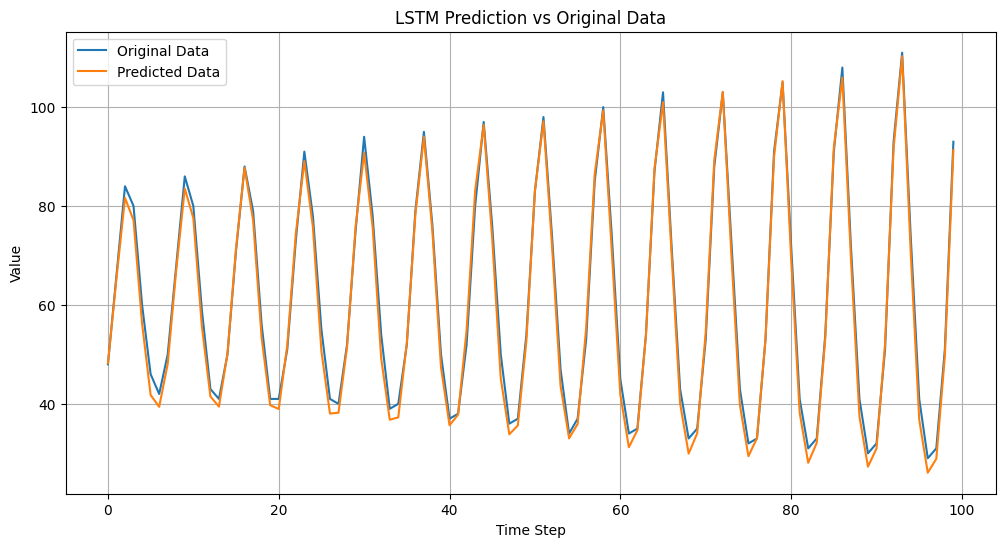

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1))[:100], label='Original Data')
plt.plot(forecast[:100], label='Predicted Data')
plt.title('LSTM Prediction vs Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50


/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0612
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0483
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0396
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0410
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0358
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0333
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0239
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0194
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0170
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0152
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0126
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0160
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0122
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0118
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107
Epoch 16/50
22/

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0540
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0419
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0394
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0375
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0300
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0208
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0168
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0171
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0156
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0164
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0141
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0138
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0105
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0113
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116
Epoch 16/50
22/

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0621
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0413
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0363
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0394
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0358
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0345
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0299
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0194
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0171
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0155
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0145
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0136
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0122
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0112
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0123
Epoch 16/50
22/

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0669
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0384
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0396
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0381
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0376
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0364
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0339
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0232
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0158
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0155
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0147
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0126
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0138
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0123
Epoch 16/50
22/

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0680
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0423
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0420
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0351
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0365
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0296
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0198
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0161
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0159
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0165
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0120
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0122
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0119
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0099
Epoch 16/50
22/

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0631
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0418
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0394
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0360
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0389
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0347
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0232
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0178
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0156
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0147
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0156
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0096
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0133
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0102
Epoch 16/50
22/

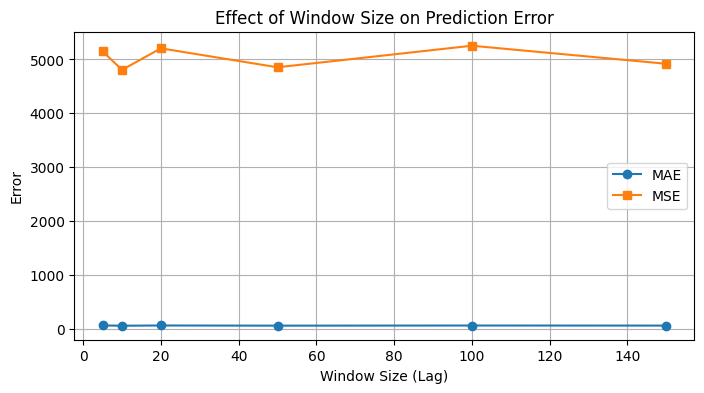

In [31]:


window_sizes = [5, 10, 20, 50, 100, 150]
maes = []
mses = []

for step in window_sizes:

    X, y = create_dataset(scaled_data, TIME_STEP)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    train_size = int(len(X) * 0.7)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    n_steps = X.shape[1]
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')


    # Train the model
    model.fit(X_train, y_train,  epochs=50, batch_size=32)


    # Forecast future values
    forecast = model.predict(X_test)
    # Inverse transform to original scale
    forecast = scaler.inverse_transform(forecast)


    mse = mean_squared_error(y_test, forecast)
    #rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, forecast)

    maes.append(mae)
    mses.append(mse)

# Plot results
plt.figure(figsize=(8,4))
plt.plot(window_sizes, maes, marker='o', label='MAE')
plt.plot(window_sizes, mses, marker='s', label='MSE')
plt.xlabel('Window Size (Lag)')
plt.ylabel('Error')
plt.title('Effect of Window Size on Prediction Error')
plt.legend()
plt.grid()
plt.savefig("effect_windowsize.jpg")
plt.show()

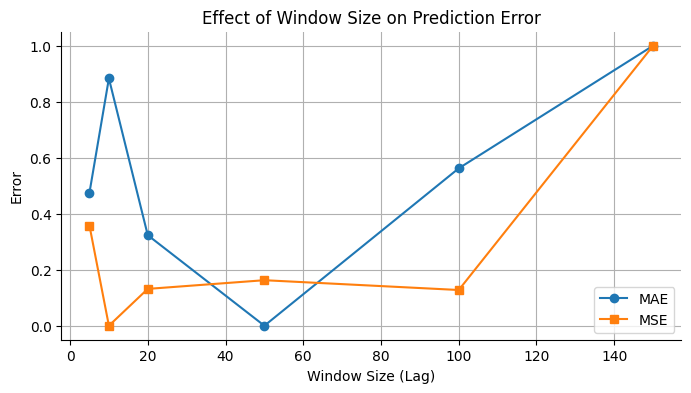

In [30]:
# Plot results
plt.figure(figsize=(8,4))

maes = np.array(maes)
mses = np.array(mses)
maes_norm = (maes - maes.min()) / (maes.max() - maes.min())
mses_norm = (mses - mses.min()) / (mses.max() - mses.min())

plt.plot(window_sizes, (maes_norm), marker='o', label='MAE')
plt.plot(window_sizes, (mses_norm), marker='s', label='MSE')
plt.xlabel('Window Size (Lag)')
plt.ylabel('Error')
plt.title('Effect of Window Size on Prediction Error')
plt.legend()
plt.grid()
plt.savefig("effect_windowsize_norm.jpg")
plt.show()